# Arctic model comparison

This notebook was created to identify the best available hydrodynamic to drive oil spill modeling in the Arctic as part of the oil spill risk assessment pipeline.

Given the rapid interannual changes in sea ice coverage, it is important to use a hydrodynamic and sea ice model that accurately represents current conditions.  Available model results include the UAF ROMS hindcast with available years 2005-2014 and HYCOM through 2017.  The ROMS hindcast is a regional model with higher resolution than the global HYCOM model.  However, the ROMS simulations end in 2014 which may inadequately represent contemporary sea ice conditions.

HYCOM presents a much strong representation of the Beaufort Gyre that appears largely suppressed in ROMS.
The increased resolution along the North Slope of ROMS yields a stronger representation of coastal currents through the Central Channel and along the Barrow Canyon than HYCOM.  Another added benefit of using ROMS is the increased reslution of the coast.

In [3]:
import glob
import os

import xarray
import numpy as np
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
from mpl_toolkits.basemap import Basemap
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# use dask
from dask.distributed import Client
from distributed import progress

In [4]:
client = Client('aracuaria.ib.axiomptk:8786')

In [5]:
client.get_versions()

{'client': {'host': [('python', '3.5.4.final.0'),
   ('python-bits', 64),
   ('OS', 'Linux'),
   ('OS-release', '3.16.0-4-amd64'),
   ('machine', 'x86_64'),
   ('processor', ''),
   ('byteorder', 'little'),
   ('LC_ALL', 'None'),
   ('LANG', 'None'),
   ('LOCALE', 'None.None')],
  'packages': {'optional': [('numpy', '1.14.2'),
    ('pandas', '0.22.0'),
    ('bokeh', '0.12.14'),
    ('lz4', None),
    ('blosc', None)],
   'required': [('dask', '0.17.2'),
    ('distributed', '1.21.4'),
    ('msgpack', '0.5.5'),
    ('cloudpickle', '0.5.2'),
    ('tornado', '5.0.1'),
    ('toolz', '0.9.0')]}},
 'scheduler': {'host': [['python', '3.5.4.final.0'],
   ['python-bits', 64],
   ['OS', 'Linux'],
   ['OS-release', '3.16.0-4-amd64'],
   ['machine', 'x86_64'],
   ['processor', ''],
   ['byteorder', 'little'],
   ['LC_ALL', 'C.UTF-8'],
   ['LANG', 'C.UTF-8'],
   ['LOCALE', 'en_US.UTF-8']],
  'packages': {'optional': [['numpy', '1.14.2'],
    ['pandas', '0.22.0'],
    ['bokeh', '0.12.14'],
    ['lz4'

## 1. Create monthly averages of surface currents from HYCOM 

Oil spill using HYCOM results downloaded from NOAA which is HYCOM + NCODA 1/12.  Which doesn't include sea-ice :/ 

The Global RTOFS model has Community Sea Ice model with data from Oct. 17, 2017.

Time dimension is not a record :/ :/ :/ 

### 1.1 Create monthly averages

In [390]:
hycom_base_path = '/data/models/c06c2f24-0f40-11e3-a373-00219bfe5678/2017/'
hycom_month_paths = {'may' : os.path.join(hycom_base_path, '2017_05'),
               'jun' : os.path.join(hycom_base_path, '2017_06'),
               'jul': os.path.join(hycom_base_path, '2017_07'),
               'aug': os.path.join(hycom_base_path, '2017_08'),
               'sep': os.path.join(hycom_base_path, '2017_09'),
               'oct': os.path.join(hycom_base_path, '2017_10'),
               'nov': os.path.join(hycom_base_path, '2017_11'),
              }

In [391]:
def calc_monthly_avg(glob_path):
    """Given path to glob, calculate the average of u and v"""
    if type(glob_path) is str:
        files = glob.glob(glob_path)
    elif type(glob_path) is list:
        files = glob_path
    else:
        raise Exception('nope.')
    
    # prep arrays for calculation
    with nc.Dataset(files[0]) as ds:
        ny = ds.dimensions['Y'].size
        nx = ds.dimensions['X'].size
    u_mean = np.zeros((ny, nx))
    v_mean = np.zeros((ny, nx))

    for f in files:
        with nc.Dataset(f) as ds:
            fname = os.path.basename(f)
            u = ds.variables['u'][0, 0, :, :]
            v = ds.variables['v'][0, 0, :, :]
#            print('{}: x({:.2f}, {:.2f}, {:.2f}), y({:.2f}, {:.2f}, {:.2f})'.format(fname, u.min(), u.max(), u.mean(),
#                                                                                           v.min(), v.max(), v.mean()))
            u_mean = u_mean + u
            v_mean = v_mean + v
    
#    print('- average of {} files'.format(len(files)))
    u_mean = u_mean / len(files)
    v_mean = v_mean / len(files)
    
    return u_mean, v_mean

In [392]:
%%time
mean = calc_monthly_avg('/data/models/c06c2f24-0f40-11e3-a373-00219bfe5678/2017/2017_05/hycom_west_coast_20170501.nc')

CPU times: user 516 ms, sys: 56 ms, total: 572 ms
Wall time: 579 ms


In [393]:
%%time
base = '/data/models/c06c2f24-0f40-11e3-a373-00219bfe5678/2017/2017_05/hycom_west_coast_201705{0:02d}.nc'
files = [base.format(i) for i in range(1, 3)]
mean = calc_monthly_avg(files)

CPU times: user 700 ms, sys: 12 ms, total: 712 ms
Wall time: 712 ms


In [394]:
%%time
base = '/data/models/c06c2f24-0f40-11e3-a373-00219bfe5678/2017/2017_05/hycom_west_coast_201705{0:02d}.nc'
files = [base.format(i) for i in range(1, 5)]
mean = calc_monthly_avg(files)

CPU times: user 980 ms, sys: 60 ms, total: 1.04 s
Wall time: 1.06 s


In [395]:
%%time
hycom_monthly_means = {}
for k, v in month_paths.items():
    path = os.path.join(v, '*.nc')
    hycom_monthly_means[k] = calc_monthly_avg(path)

CPU times: user 33.8 s, sys: 1.66 s, total: 35.5 s
Wall time: 36.2 s


### 1.2 Create monthly plots of HYCOM surface currents

In [396]:
ds = nc.Dataset('/data/models/c06c2f24-0f40-11e3-a373-00219bfe5678/2017/2017_05/hycom_west_coast_20170501.nc')
hycom_lat = ds.variables['Latitude'][:]
hycom_lon = ds.variables['Longitude'][:]
ds.close()

In [398]:
def plot_hycom_surface_current(lon, lat, u, v, month, step=10):
    crs = cartopy.crs.PlateCarree()
    land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                                   edgecolor='gray',
                                                   facecolor=cartopy.feature.COLORS['land']
                                                  )
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=crs)
    ax.set_xmargin(0.05)
    ax.set_ymargin(0.10)
    ax.add_feature(land_10m)
    ax.gridlines(zorder=2, color='lightgray')
    ax.coastlines('50m')
    ax.set_extent([-170, -140, 68, 80], crs)

    u = u[::step, ::step]
    v = v[::step, ::step]
    lon = lon[::step, ::step]
    lat = lat[::step, ::step]
    speed = np.sqrt(u**2 + v**2)
    values = np.linspace(0, 0.5, 6, endpoint=True)
    cs = ax.contourf(lon,
                     lat,
                     speed,
                     values,
                     transform=crs,
                    )
    cbar = fig.colorbar(cs, ax=ax, ticks=values)
    cbar.set_label('Speed (m/s)', fontsize=12)


    q = ax.quiver(lon,
                  lat,
                  u,
                  v,
                  transform=crs,
                  color='k',
                  scale=10
                  )
    # colorbar same size as figure
    ax.set_aspect('auto')


    plt.title('HYCOM monthly averaged surface currents', fontsize=16)
    plt.text(-146, 68.5, '{} 2017'.format(month), fontsize=18)

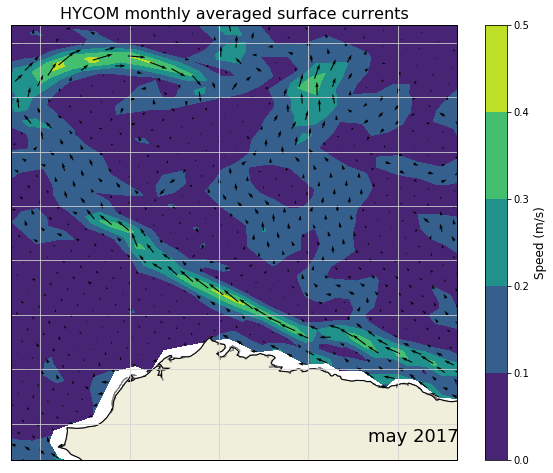

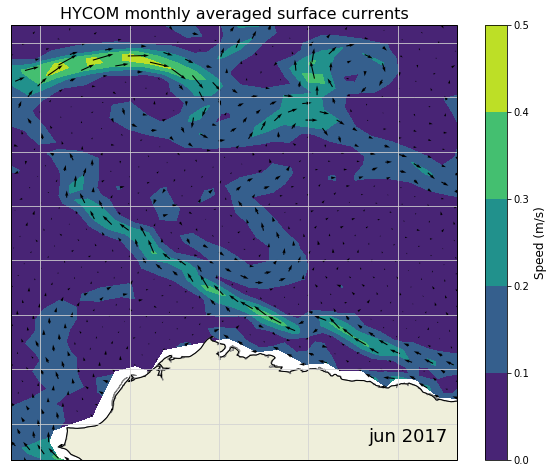

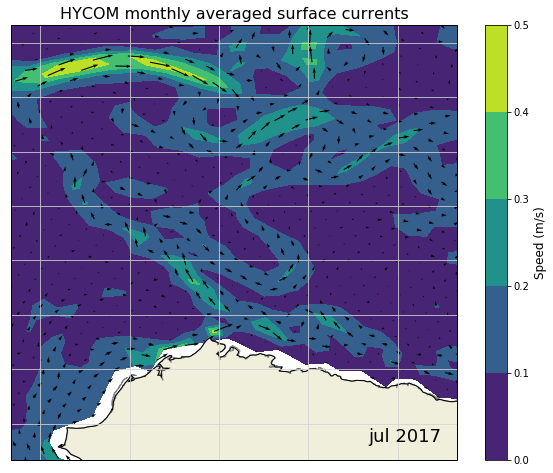

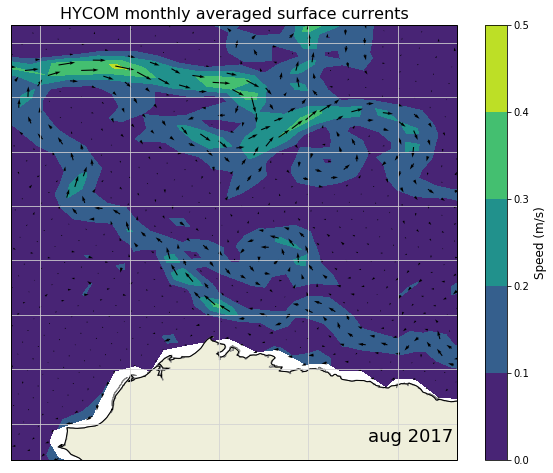

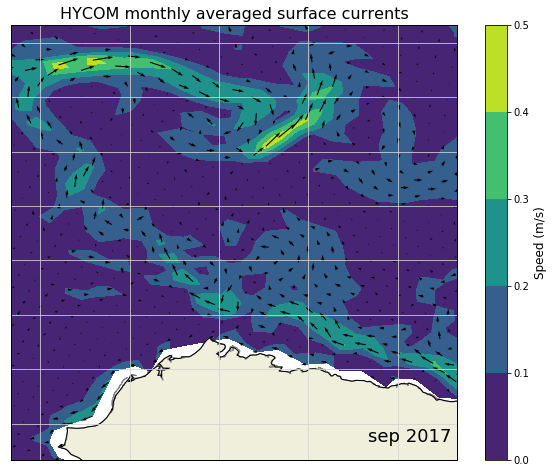

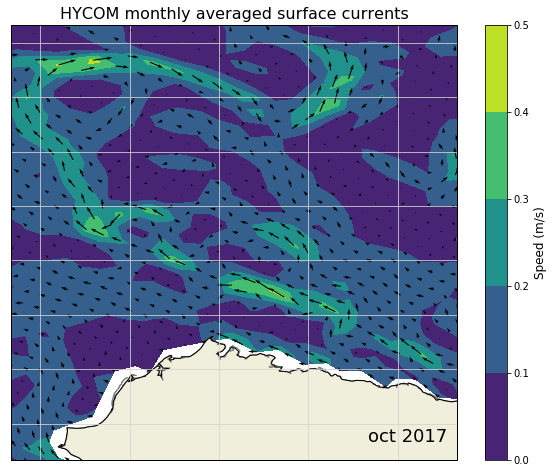

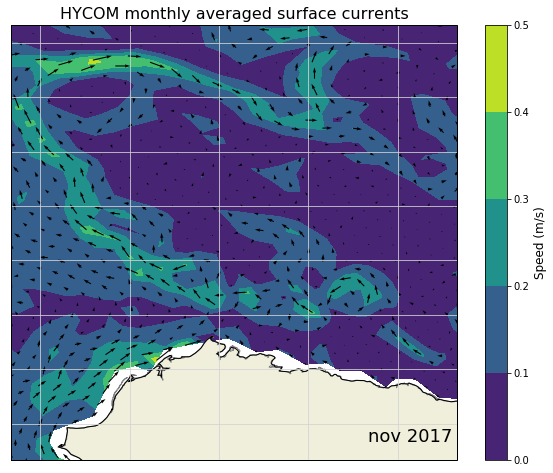

In [399]:
for k in ['may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']:
    u = hycom_monthly_means[k][0]
    v = hycom_monthly_means[k][1]
    plot_hycom_surface_current(hycom_lon, hycom_lat, u, v, k)

## 2. Create monthly averages of surface currents from ROMS


In [401]:
roms_base_path = '../../../assets/osra-2017/arctic_roms/'
roms_months_paths = {i: os.path.join(roms_base_path, 'arctic2_avg2_2015-{:02d}-*T.nc'.format(i)) 
               for i in range(5, 12)}

In [402]:
roms_months_paths

{5: '../../../assets/osra-2017/arctic_roms/arctic2_avg2_2015-05-*T.nc',
 6: '../../../assets/osra-2017/arctic_roms/arctic2_avg2_2015-06-*T.nc',
 7: '../../../assets/osra-2017/arctic_roms/arctic2_avg2_2015-07-*T.nc',
 8: '../../../assets/osra-2017/arctic_roms/arctic2_avg2_2015-08-*T.nc',
 9: '../../../assets/osra-2017/arctic_roms/arctic2_avg2_2015-09-*T.nc',
 10: '../../../assets/osra-2017/arctic_roms/arctic2_avg2_2015-10-*T.nc',
 11: '../../../assets/osra-2017/arctic_roms/arctic2_avg2_2015-11-*T.nc'}

In [403]:
# Get grid information
grid = nc.Dataset('../../../assets/osra-2017/arctic_roms/grid_Arctic_2.nc')
grid.variables.keys()
roms_lat = grid.variables['lat_rho'][:]
roms_lon = grid.variables['lon_rho'][:] - 360
grid.close()

In [404]:
# mask to small area
lon_mask = np.logical_and(roms_lon > -172, roms_lon < -138)
lat_mask = np.logical_and(roms_lat < 82, roms_lat > 66)
mask = np.invert(np.logical_and(lat_mask, lon_mask))

In [405]:
def compute_daily_mean(f):
    """Compute daily mean from daily file"""
    with nc.Dataset(f) as ds:
        return (np.ma.mean(ds.variables['u_eastward'][:], axis=0),
                np.ma.mean(ds.variables['v_northward'][:], axis=0))

In [406]:
def plot_roms_surface_currents(lon, lat, u, v, month, step=5):
    crs = cartopy.crs.PlateCarree()
    land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                                   edgecolor='gray',
                                                   facecolor=cartopy.feature.COLORS['land']
                                                  )
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=crs)
    ax.set_xmargin(0.05)
    ax.set_ymargin(0.10)
    ax.add_feature(land_10m)
    ax.gridlines(zorder=2, color='lightgray')
    ax.coastlines('50m')
    ax.set_extent([-170, -140, 68, 80], crs)

    u_sub = u[::step, ::step]
    v_sub = v[::step, ::step]
    lon_sub = lon[::step, ::step]
    lat_sub = lat[::step, ::step]
    speed = np.sqrt(u_sub**2 + v_sub**2)
    values = np.linspace(0, 0.5, 6, endpoint=True)
    cs = ax.contourf(lon_sub,
                     lat_sub,
                     speed,
                     values,
                     transform=crs,
                    )
    cbar = fig.colorbar(cs, ax=ax, ticks=values)
    cbar.set_label('Speed (m/s)', fontsize=12)


    q = ax.quiver(lon_sub,
                  lat_sub,
                  u_sub,
                  v_sub,
                  transform=crs,
                  color='k',
                  scale=10
                 )
    # just want qualitative check, so minus all this noise
    #plt.quiverkey(q, -148, 68.5, 1, r'1 m/s', coordinates='data')
    ax.set_aspect('auto')

    plt.title('ROMS monthly averaged surface currents', fontsize=16)
    plt.text(-146, 68.5, '{} 2015'.format(month), fontsize=18)

In [407]:
%%time
# Get monthly means for all data
roms_monthly_means = {}
for k, v in months_paths.items():
    file_paths = glob.glob(months_paths[k])
    # fix paths to workers can use them for may
    gluster_paths = [f.replace('../../../', '/data/') for f in file_paths]
    futures = client.map(compute_daily_mean, gluster_paths)
    daily_means = np.asarray(client.gather(futures))
    
    u = daily_means[:, 0, :, :].mean(axis=0)
    v = daily_means[:, 1, :, :].mean(axis=0)
    u[mask] = np.nan
    v[mask] = np.nan
    
    roms_monthly_means[k] = (u, v)

CPU times: user 9.29 s, sys: 9.7 s, total: 19 s
Wall time: 1min 43s


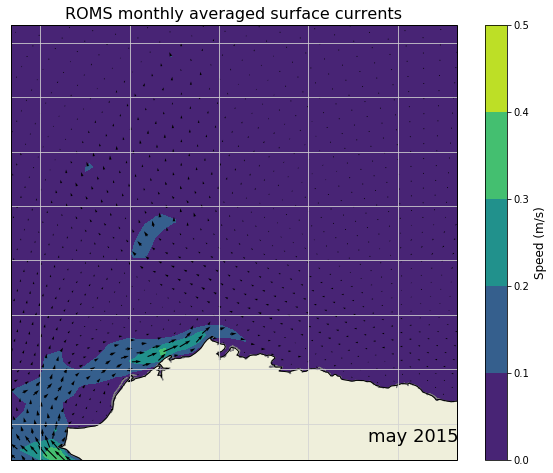

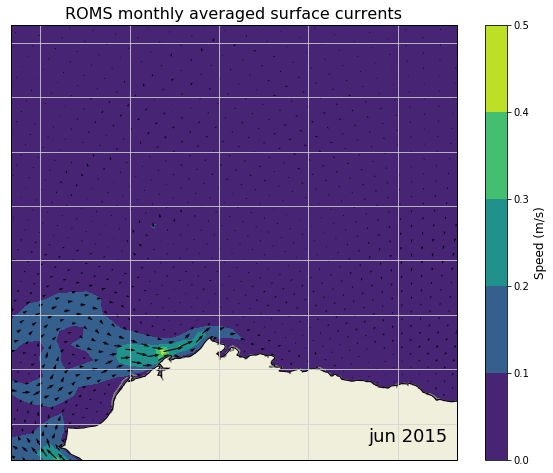

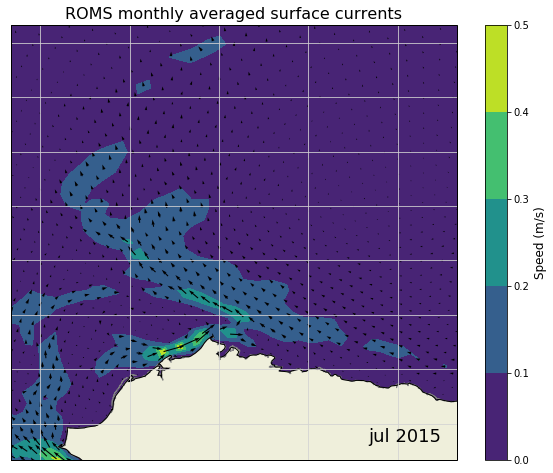

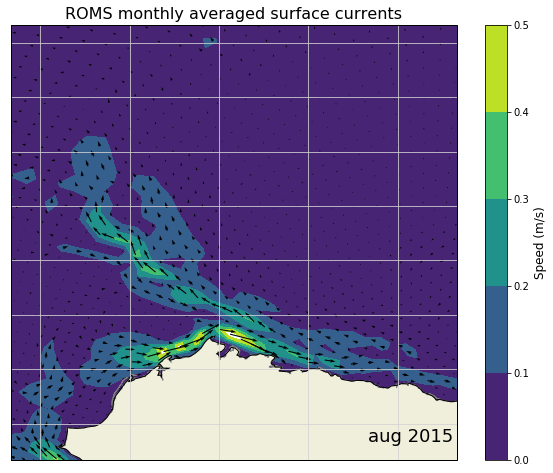

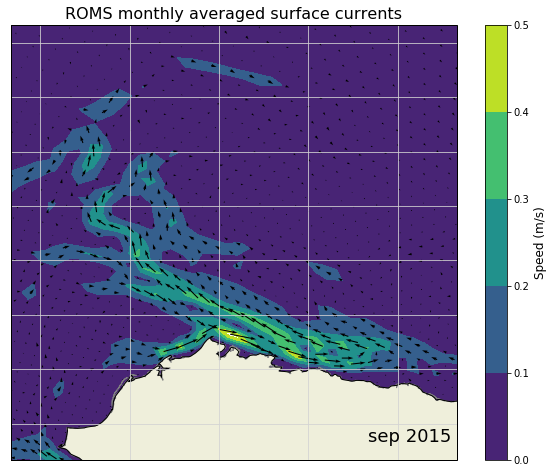

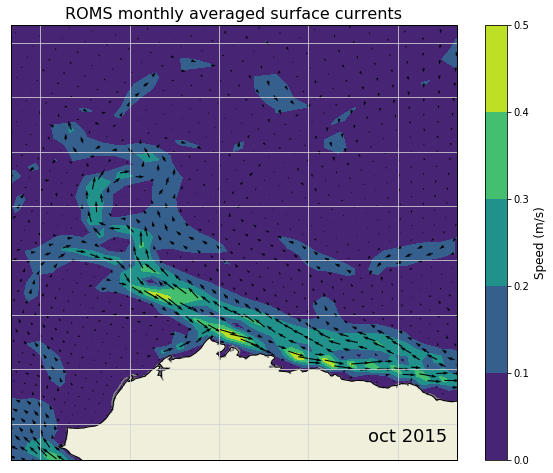

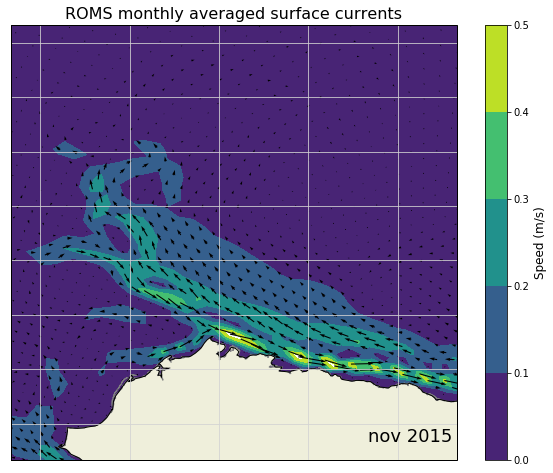

In [408]:
for i, k in zip(range(5, 12), ['may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']):
    u = roms_monthly_means[i][0]
    v = roms_monthly_means[i][1]
    plot_roms_surface_currents(lon, lat, u, v, k)

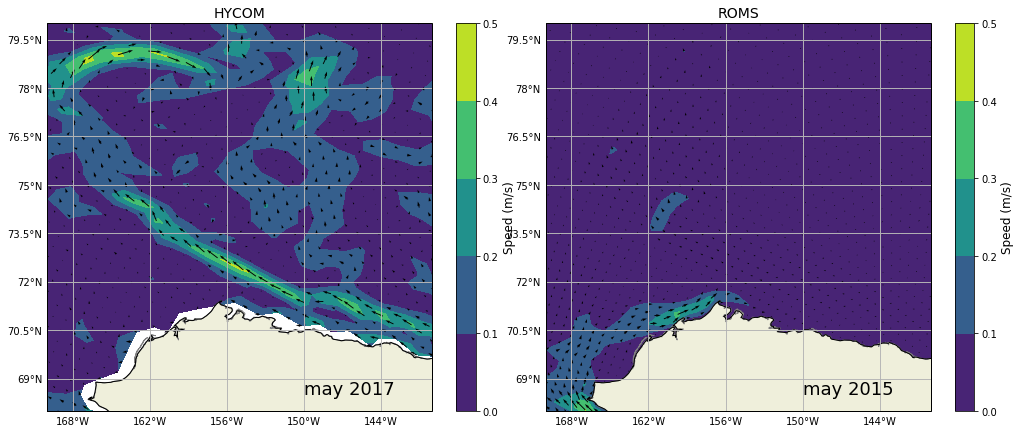

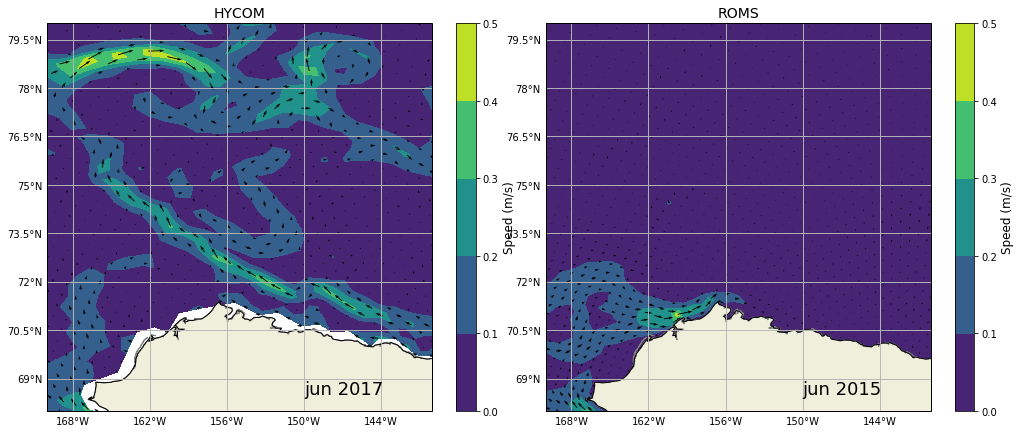

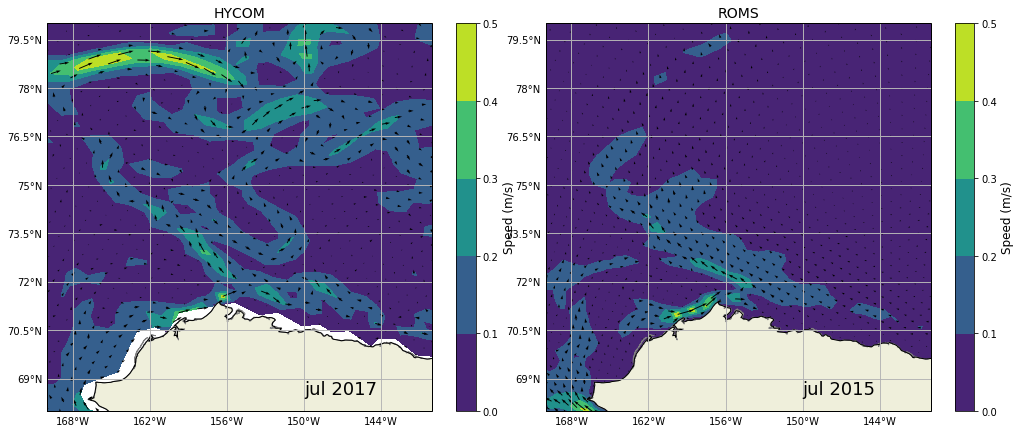

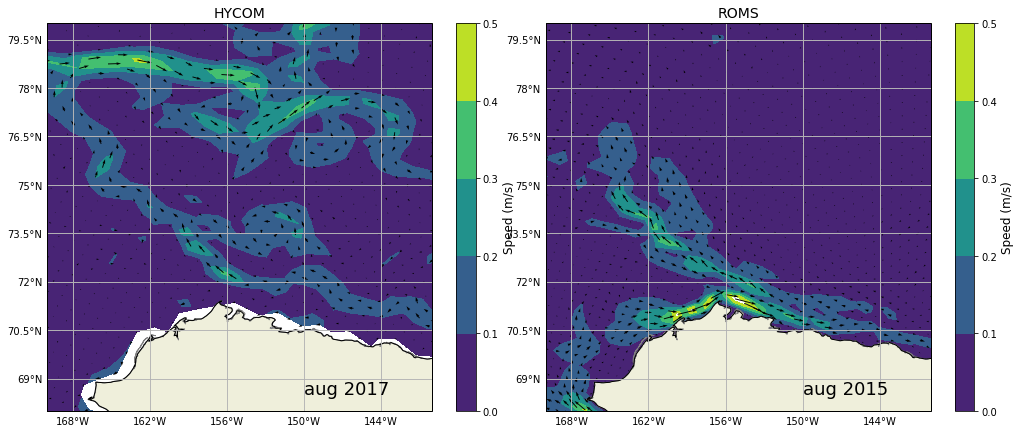

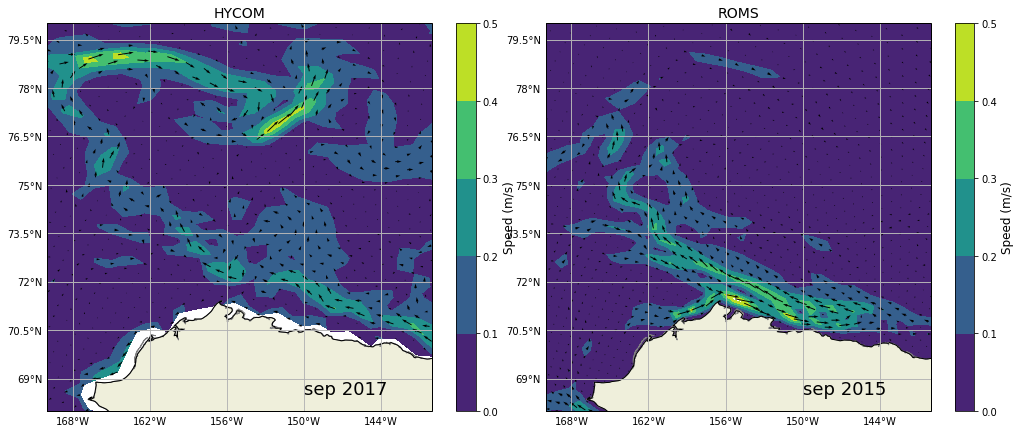

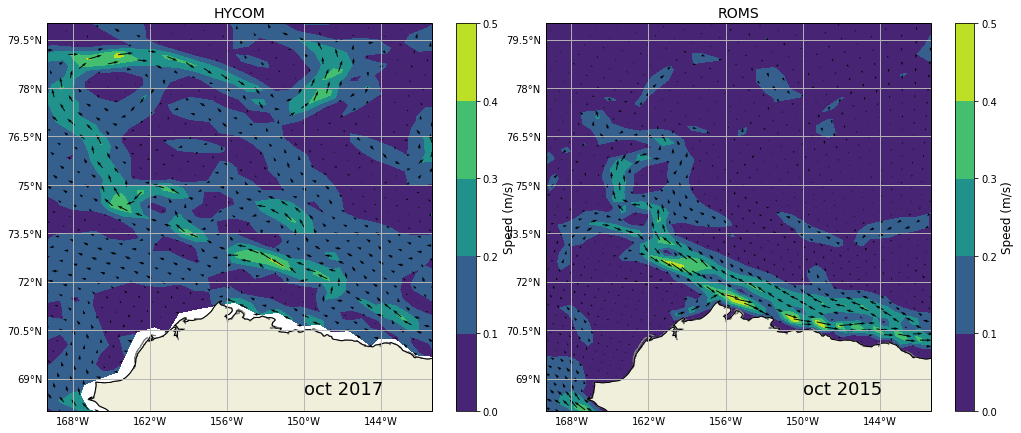

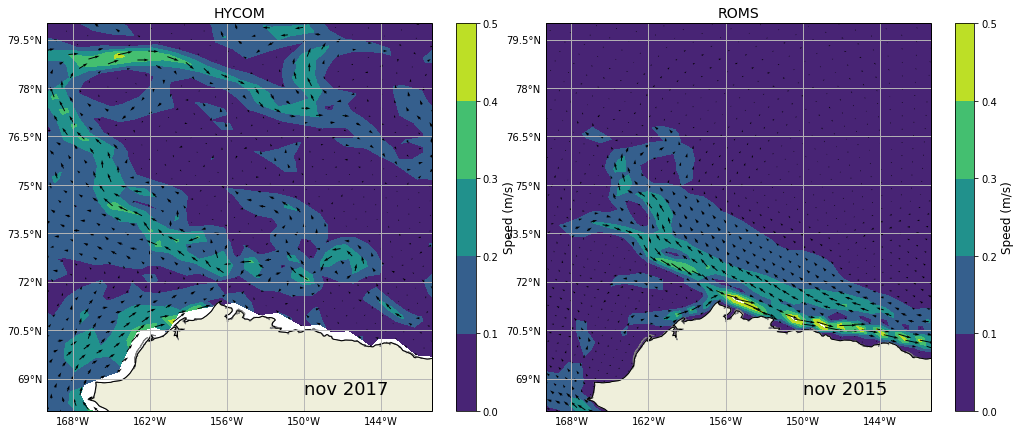

In [440]:
roms_step = 5
roms_lon_sub = roms_lon[::roms_step, ::roms_step]
roms_lat_sub = roms_lat[::roms_step, ::roms_step]

hycom_step = 10
hycom_lon_sub = hycom_lon[::hycom_step, ::hycom_step]
hycom_lat_sub = hycom_lat[::hycom_step, ::hycom_step]

for i, k in zip(range(5, 12), ['may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']):
    roms_u = roms_monthly_means[i][0][::roms_step, ::roms_step]
    roms_v = roms_monthly_means[i][1][::roms_step, ::roms_step]
    roms_speed = np.sqrt(roms_u**2 + roms_v**2)
    
    hycom_u = hycom_monthly_means[k][0][::hycom_step, ::hycom_step]
    hycom_v = hycom_monthly_means[k][1][::hycom_step, ::hycom_step]
    hycom_speed = np.sqrt(hycom_u**2 + hycom_v**2)
    
    values = np.linspace(0, 0.5, 6, endpoint=True)
    
    crs = cartopy.crs.PlateCarree()
    land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                                   edgecolor='gray',
                                                   facecolor=cartopy.feature.COLORS['land']
                                                   )
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': crs})
    
    for ax in axes:
        ax.set_xmargin(0.05)
        ax.set_ymargin(0.10)
        ax.add_feature(land_10m)
        ax.gridlines(zorder=2, color='lightgray')
        ax.coastlines('50m')
        ax.add_feature(cartopy.feature.RIVERS)
        ax.set_extent([-170, -140, 68, 80], crs)
        ax.set_aspect('auto')
        
        g1 = ax.gridlines(crs=crs, draw_labels=True)
        g1.xformatter = LONGITUDE_FORMATTER
        g1.yformatter = LATITUDE_FORMATTER
        g1.xlabels_top = False
        g1.ylabels_right = False
    
    # hycom on the left, roms on the right
    axes[0].set_title('HYCOM', fontsize=14)
    cs = axes[0].contourf(hycom_lon_sub,
                          hycom_lat_sub,
                          hycom_speed,
                          values,
                          transform=crs,
                         )
    cbar = fig.colorbar(cs, ax=axes[0], ticks=values)
    cbar.set_label('Speed (m/s)', fontsize=12)
    q = axes[0].quiver(hycom_lon_sub,
                       hycom_lat_sub,
                       hycom_u,
                       hycom_v,
                       transform=crs,
                       color='k',
                       scale=0.5,
                       units='xy'
                      )
    axes[0].text(-150, 68.5, '{} 2017'.format(k), fontsize=18)

    
    # roms
    axes[1].set_title('ROMS', fontsize=14)
    cs = axes[1].contourf(roms_lon_sub,
                          roms_lat_sub,
                          roms_speed,
                          values,
                          transform=crs,
                         )
    
    q = axes[1].quiver(roms_lon_sub,
                       roms_lat_sub,
                       roms_u,
                       roms_v,
                       transform=crs,
                       color='k',
                       scale=0.5,
                       units='xy'
                      )
    cbar = fig.colorbar(cs, ax=axes[1], ticks=values)
    cbar.set_label('Speed (m/s)', fontsize=12)
    axes[1].text(-150, 68.5, '{} 2015'.format(k), fontsize=18)

    plt.tight_layout(h_pad=0.1)

HFR surface currents maps: http://research.cfos.uaf.edu/chukchi-beaufort/data/hfr/index.php?year=2015&month=10&day=1